This script analyze the output of O<sub>3</sub> box model with source apportionment technique. The goal of this script is to find the O<sub>3</sub> contribution from different source of VOCs from the box model for Redlands, CA

In [2]:
import os, importlib, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import join, isfile
sys.path.append('../../code/src')
#importlib.reload(sys.modules['box_model_source_apportionment'])
from box_model_source_apportionment import treat_box_model_output

In [3]:
df_all = pd.DataFrame(columns=['Date','Time','O3','O3_X1','O3_X2','O3_X3',
                                 'O3_X4','O3_X5','O3_X6',
                                 'O3_X7','O3_X8','O3_X9'])
folderpath = '../../data/intermediate/box_model_output_bgX/'
filelist = [f for f in listdir(folderpath) if 
            isfile(join(folderpath, f))]
filelist = [s for s in filelist if 'results' in s ]

for file in filelist:
    filepath = folderpath + file
    df = treat_box_model_output(filepath)
    df_all = pd.concat([df_all, df], ignore_index=True)

# Precentage of PMF-input VOCs formed O<sub>3</sub> to total O<sub>3</sub> formation 

In [4]:
df_O3_source_avg = pd.DataFrame(df_all[df_all['Time']==180].iloc[:,2:].mean(axis=0))
df_O3_source_avg.columns = ['Value']

# Subtract the initial O3 from final O3_vanilla
O3_init_avg = df_all[df_all['Time']==0].iloc[:,2:].mean(axis=0)[0]
df_O3_source_avg.iloc[0,0] = df_O3_source_avg.iloc[0,0] - O3_init_avg

# calculate the percentage to sum
df_O3_source_avg['Percentage'] = df_O3_source_avg['Value']/df_O3_source_avg['Value'].sum()*100

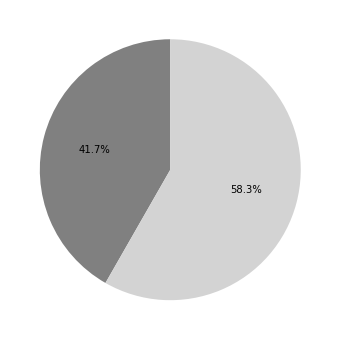

In [5]:
O3_not_in_PMF = df_O3_source_avg.loc['O3','Percentage']
O3_in_PMF = 100 - O3_not_in_PMF
pie = [O3_not_in_PMF, O3_in_PMF]

fig, ax = plt.subplots(1, figsize=(6, 6))
ax.pie(pie, autopct='%1.1f%%',
        shadow=False, startangle=90, colors = ['grey','lightgrey'])
fig.set_facecolor('white')
fig.savefig('../../result/pie_model_PMFinput_vs_notinPMF.png', dpi=1200, bbox_inches='tight')

# O<sub>3</sub> source apportionment of PMF-solved factors

C:\Users\Shenglun\AppData\Local\Temp/ipykernel_5272/2676488014.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_O3_source_novanilla['Precentage'] = \


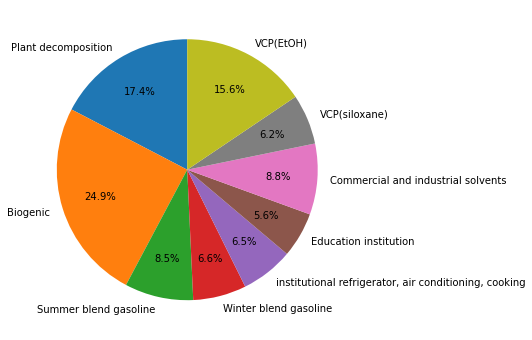

In [6]:
# calculate precentage without vanilla O3
df_O3_source_novanilla = df_O3_source_avg.iloc[1:,:]
df_O3_source_novanilla['Precentage'] = \
    df_O3_source_novanilla['Value']/df_O3_source_novanilla['Value'].sum()

# reorder source of O3 to match the order in OFP analysis
idx = ['O3_X1','O3_X3','O3_X5','O3_X4','O3_X9','O3_X8','O3_X6','O3_X7','O3_X2']
df_O3_source_novanilla = df_O3_source_novanilla.loc[idx,:]

# make pie chart (no vanilla)
fig, ax=plt.subplots(1, figsize=(6, 6))
factor_name = ['Plant decomposition', 'Biogenic', 'Summer blend gasoline',
               'Winter blend gasoline', 'institutional refrigerator, air conditioning, cooking', 'Education institution', 'Commercial and industrial solvents', 
               'VCP(siloxane)', 'VCP(EtOH)']

ax.pie(df_O3_source_novanilla['Percentage'], labels=factor_name, 
       autopct='%.1f%%', pctdistance=0.7,shadow=False, startangle=90, textprops={'fontsize': 10})
fig.set_facecolor('white')
fig.savefig('../../result/pie_model_O3_source.png', dpi=1200, bbox_inches='tight')

<AxesSubplot:xlabel='Date'>

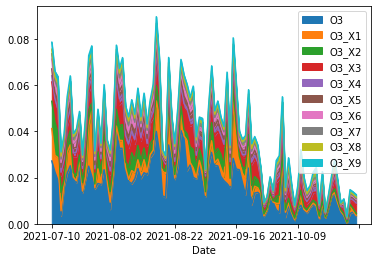

In [14]:
# plot stacked time series
df_plot = df_all.loc[df_all['Time']==180, ['Date','O3','O3_X1','O3_X2','O3_X3','O3_X4',
                      'O3_X5','O3_X6','O3_X7','O3_X8','O3_X9']].reset_index(drop=True)
df_plot['O3'] = df_plot['O3'] - df_all[df_all['Time']==0].reset_index()['O3']
df_plot = df_plot.set_index('Date')

df_plot.plot.area()

In [103]:
# Get vanilla, sources, total and initial O3
df_O3_source = df_all[df_all['Time']==180].reset_index(drop=True)
df_O3_source['O3_tot'] = df_O3_source.iloc[:,2:].sum(axis=1)
df_O3_source['O3_int'] = df_all[df_all['Time']==0].reset_index()['O3']

# calculate total O3 from PMF sources
df_O3_source['O3_tot_source'] = df_O3_source['O3_tot'] - df_O3_source['O3']

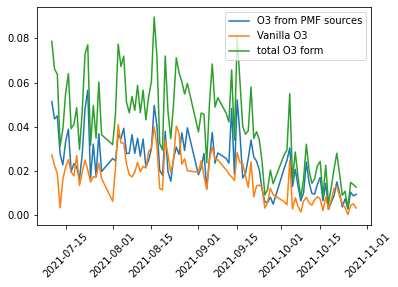

In [106]:
# Plot O3 formed from PMF sources vs. total O3 or vanilla O3
#plt.plot(df_O3_source['Date'], df_O3_source['O3_tot'], label='Total O3')
plt.plot(df_O3_source['Date'], df_O3_source['O3_tot_source'], label='O3 from PMF sources')
plt.plot(df_O3_source['Date'], df_O3_source['O3'] - df_O3_source['O3_int'], label='Vanilla O3')
plt.plot(df_O3_source['Date'], df_O3_source['O3_tot']-df_O3_source['O3_int'], label='total O3 form')

plt.xticks(rotation=45)
plt.legend()

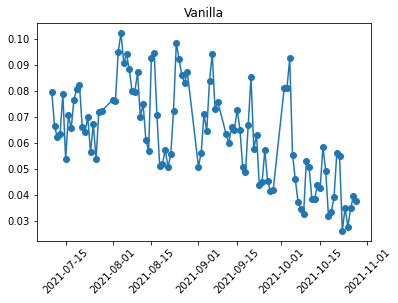

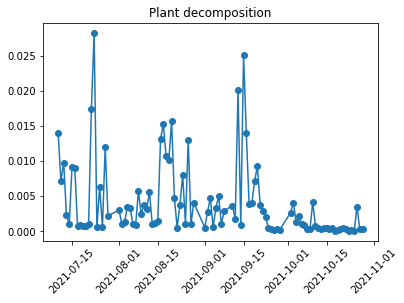

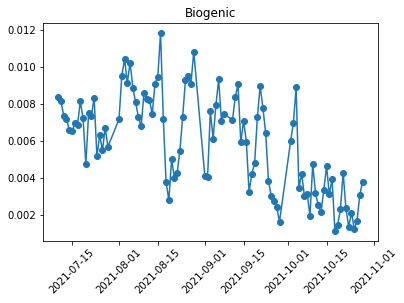

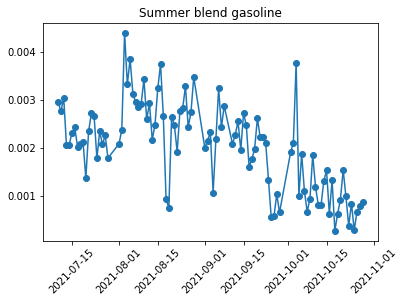

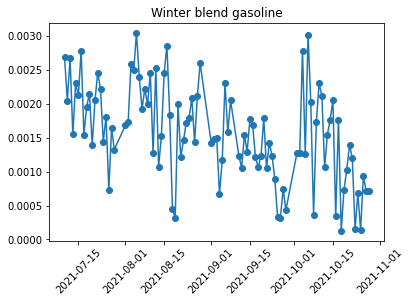

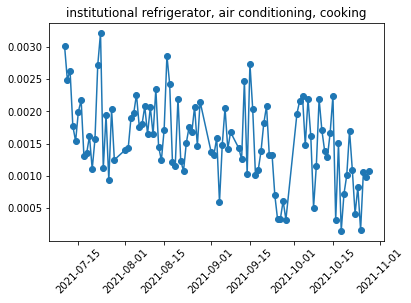

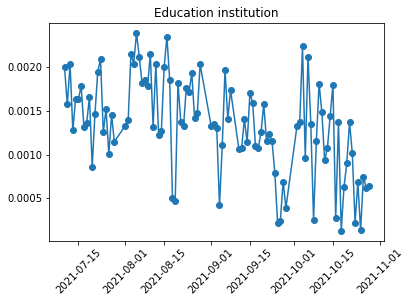

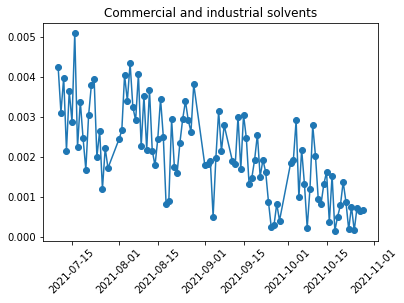

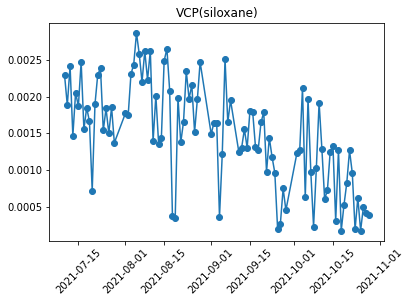

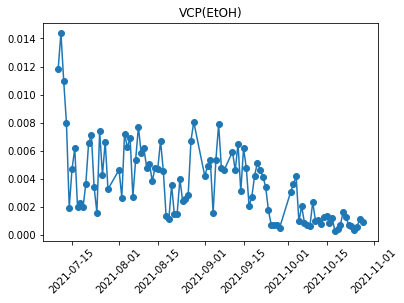

In [74]:
factor_order_withvanilla = ['O3'] + idx # the right order of source factors (corespond to the factor name)
factor_name_withvanilla = ['Vanilla','Plant decomposition', 'Biogenic', 
                           'Summer blend gasoline', 'Winter blend gasoline', 
                           'institutional refrigerator, air conditioning, cooking',
                           'Education institution', 'Commercial and industrial solvents','VCP(siloxane)', 'VCP(EtOH)']
                           
for i in range(10):
    plt.scatter(df_O3_source['Date'], 
                df_O3_source[factor_order_withvanilla[i]])
    plt.plot(df_O3_source['Date'], 
             df_O3_source[factor_order_withvanilla[i]])
    plt.title(factor_name_withvanilla[i])
    plt.xticks(rotation=45)
    plt.show()

In [67]:
for i in col:
    r_value = df_O3_source['O3_tot'].corr(df_O3_source[i])
    print('r_value for ' + i + ' is: ' + str(r_value)) 

r_value for O3 is: 0.9502581320597028
r_value for O3_X1 is: 0.5024527711009591
r_value for O3_X2 is: 0.7323247363318407
r_value for O3_X3 is: 0.9036130205395608
r_value for O3_X4 is: 0.7281769543235177
r_value for O3_X5 is: 0.9096434395878266
r_value for O3_X6 is: 0.8689393013535092
r_value for O3_X7 is: 0.850087071110771
r_value for O3_X8 is: 0.7995533541612958
r_value for O3_X9 is: 0.7554188125224117
